# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
# !pip install aiogram==2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

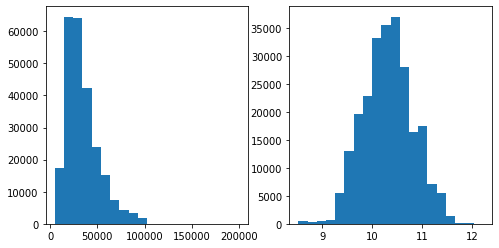

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
131207,70185764,National Foster Care Manager,National Foster Care Manager Foster Care Lear...,"City of London, London",The City,NaN,permanent,Coburg Banks Limited,Social work Jobs,44800/annum,44800,cv-library.co.uk,10.709986
30050,68061346,SEO Executive,"SEO Executive, West Midlands, up to ****pa Our...",West Midlands,West Midlands,NaN,permanent,Blue Skies Marketing Recruitment,"PR, Advertising & Marketing Jobs",24000 to 26000 per annum - Competitive,25000,totaljobs.com,10.126671
187636,71681337,Supplier Officer,Supplier Officer required exercise the resourc...,Cambridge Cambridgeshire East Anglia,UK,NaN,permanent,Michael Page Procurement & Supply Chain,Other/General Jobs,35000 to 45000 per annum,40000,totaljobs.com,10.596660


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


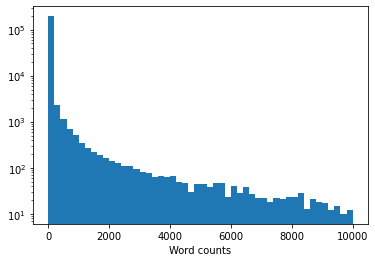

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [20]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn
import torch.functional as F

In [23]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [24]:
model = SalaryPredictor()

In [25]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [26]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [27]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 10
DEVICE = torch.device('cuda')

In [28]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=DEVICE, print_info=True, **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    if print_info:
#         print("%s results:" % (name or ""))
        print("mse: %.5f" % mse, end=' ')
        print("mae: %.5f" % mae, end=' ')
    return mse, mae

In [29]:
def plot_metrics(metrics):
    fig, ax = plt.subplots()
    for label in ('mse', 'mae', 'loss'):
        ax.plot(metrics[label], label = label)
    ax.legend(['mse', 'mae', 'loss'])
    fig.suptitle(f'mse, mae, loss metrics')
    plt.show()

In [30]:
def train(model, criterion, optimizer, epochs=EPOCHS, batch_size=BATCH_SIZE, device=DEVICE):
    metrics = {
        label: [] for label in ('mse', 'mae', 'loss')
    }
    print(epochs)
    for epoch in range(epochs):
        loss = None
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=batch_size, 
                        device=device)), 
                    total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()
        print(f"epoch: {epoch}")
        print("train_loss: %.5f" % loss.item(), end=' ')
        print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
        print()
        mse, mae = print_metrics(model, data_val, print_info=False)
        metrics['mse'].append(mse)
        metrics['mae'].append(mae)
        metrics['loss'].append(loss.item())
    return metrics

In [31]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
metrics = train(model, criterion, optimizer, epochs=8)

8


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 3.51734 mse: 0.61532 mae: 0.37956 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.74127 mse: 0.36841 mae: 0.29058 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.58591 mse: 0.26170 mae: 0.24268 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.39834 mse: 0.18154 mae: 0.19896 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.05084 mse: 0.18462 mae: 0.20165 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.48198 mse: 0.16021 mae: 0.18672 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.04033 mse: 0.18012 mae: 0.19984 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.19158 mse: 0.15043 mae: 0.18079 


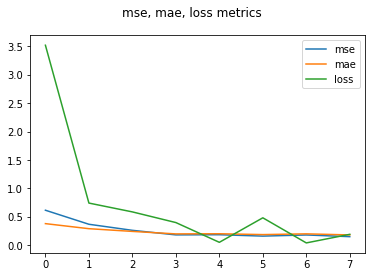

In [33]:
plot_metrics(metrics)

**1. Развейте СNN архитектуру (2 балла)**

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано. 

Как модель ведет себя в зависимости от количества обучаемых параметров?


In [34]:
class SalaryPredictor_BatchNorm(SalaryPredictor):

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()

        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size * 2, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv1d(hid_size * 2, hid_size * 4, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size * 2, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv1d(hid_size * 2, hid_size * 4, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.LazyLinear(hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1))
        

In [35]:
model_BatchNorm = SalaryPredictor_BatchNorm().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_BatchNorm.parameters(), lr=2.2e-3)
metrics = train(model_BatchNorm, criterion, optimizer, epochs=6)

6


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.19340 mse: 0.29017 mae: 0.22653 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 2.46305 mse: 0.85076 mae: 0.43801 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.21167 mse: 0.04667 mae: 0.08480 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.72787 mse: 0.04611 mae: 0.08395 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.73024 mse: 0.04378 mae: 0.08174 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.46513 mse: 0.07171 mae: 0.10767 


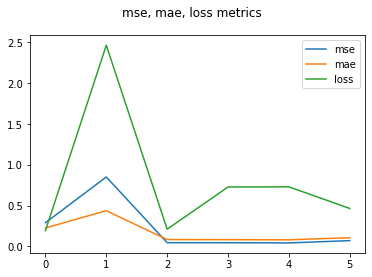

In [36]:
plot_metrics(metrics)

In [37]:
def convSequential(hid_size):
    return nn.Sequential(
        nn.Conv1d(hid_size, hid_size * 2, kernel_size=(2, )),
        nn.LazyBatchNorm1d(),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Conv1d(hid_size * 2, hid_size * 4, kernel_size=(2, )),
        nn.LazyBatchNorm1d(),
        nn.Dropout(p=0.4),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )

class SalaryPredictor_ParallelConvLayers(SalaryPredictor):

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()

        self.title_features1 = convSequential(hid_size)
        self.title_features2 = convSequential(hid_size)
        self.description_features1 = convSequential(hid_size)
        self.description_features2 = convSequential(hid_size)
        self.categorical_encoder = nn.Sequential(
            nn.LazyLinear(hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1))
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features1 = self.title_encoder(title_embeddings).squeeze()
        title_features2 = self.title_encoder(title_embeddings).squeeze()
        
        title_features = torch.cat([
            title_features1,
            title_features2
        ], dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features1 = self.description_encoder(description_embeddings).squeeze()
        description_features2 = self.description_encoder(description_embeddings).squeeze()
        
        description_features = torch.cat([
            description_features1,
            description_features1
        ], dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()
        

In [38]:
model_ParallelConvLayers = SalaryPredictor_ParallelConvLayers().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_ParallelConvLayers.parameters(), lr=5e-4)
metrics = train(model_ParallelConvLayers, criterion, optimizer, epochs=6)

6


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.72285 mse: 0.07182 mae: 0.10575 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.74166 mse: 0.06310 mae: 0.09890 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 4.16441 mse: 0.08033 mae: 0.11277 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 3.99926 mse: 0.25517 mae: 0.19257 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.54403 mse: 0.06064 mae: 0.09783 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 17.41314 mse: 2.86078 mae: 0.53760 


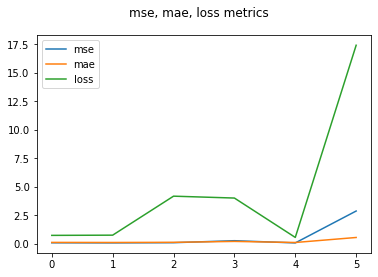

In [39]:
plot_metrics(metrics)

Когда у нас есть параллельные ядра свёртки результат быстро становится очень хорошим а потом ухудшается. Это происходит потому, что если нас 1 ядро свёртки, то у нас последовательно с помощью обучения находится оптимальные ядра, которые выделяют самые лучшие паттерны для результата. А когда у нас несколько таких ядер параллельно то у нас в силу того что ядра инициализируется из них быстрее находится оптимальный паттерн в данных и соответственно быстрее начинает переобучаться.

Добавим раннюю остановку процесс обучения многослойной модели

In [40]:
import copy
def train_with_early_stop(model, criterion, optimizer, epochs=EPOCHS, batch_size=BATCH_SIZE, device=DEVICE):
    metrics = {
        label: [] for label in ('mse', 'mae', 'loss')
    }
    print(epochs)
    for epoch in range(epochs):
        loss = None
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=batch_size, 
                        device=device)), 
                    total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()
        print(f"epoch: {epoch}")
        print("train_loss: %.5f" % loss.item(), end=' ')
        print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
        print()
        if epoch > 3:
            if loss.item() > loss_item_:
                print("Early stopping")
                break
        loss_item_ = loss.item()
        mse, mae = print_metrics(model, data_val, print_info=False)
        metrics['mse'].append(mse)
        metrics['mae'].append(mae)
        metrics['loss'].append(loss.item())
        

    return metrics

In [41]:
model_ParallelConvLayers_with_early_stop = SalaryPredictor_ParallelConvLayers().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_ParallelConvLayers_with_early_stop.parameters(), lr=5e-4)
metrics = train_with_early_stop(model_ParallelConvLayers_with_early_stop, criterion, optimizer, epochs=10)

10


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.92714 mse: 0.18758 mae: 0.16909 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 1.32673 mse: 0.06305 mae: 0.09930 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 1.42511 mse: 0.24507 mae: 0.16714 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 4.26267 mse: 0.35974 mae: 0.19212 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.83722 mse: 0.05434 mae: 0.09185 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 3.92348 mse: 0.08868 mae: 0.11963 
Early stopping


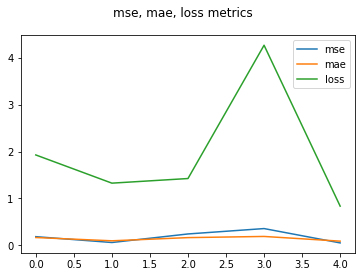

In [42]:
plot_metrics(metrics)

Как мы видим, действительно, Early Stopping позволил добиться самых лучших результатов

In [43]:
from aiogram import Bot, Dispatcher
import aiohttp
bot = Bot(token='916128449:AAFYAAYEAE-HMVLb9s2IFy2gXqLonr7G3Ts')
await bot.send_message(385778185, 'test')
await bot.close()

**2. Pooling слои стандартные (1 балла)**

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

*Pooling слои используются для уменьшения размерности карты признаков. Таким образом, уменьшается количество параметров для обучения и объем вычислений, выполняемых в сети.*

In [44]:
class SalaryPredictor_Pooling(SalaryPredictor):

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=8, pooling_func=None):
        super().__init__()
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size*2),
            nn.ELU(),
            nn.Linear(hid_size*2, 1)
        )

        self.avg_pooling1 = nn.Sequential(pooling_func(output_size=hid_size//2))
        self.avg_pooling2 = nn.Sequential(pooling_func(output_size=hid_size//2))
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings)
        title_features = self.avg_pooling1(title_features)
        title_features = torch.flatten(title_features, start_dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings)
        description_features = self.avg_pooling2(description_features)
        description_features = torch.flatten(description_features, start_dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()
        

In [45]:
model_AvgPooling = SalaryPredictor_Pooling(pooling_func=nn.AdaptiveAvgPool1d).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_AvgPooling.parameters(), lr=5e-4)
metrics = train_with_early_stop(model_AvgPooling, criterion, optimizer, epochs=10)

10


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 2.40096 mse: 0.10249 mae: 0.11924 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 2.94222 mse: 0.07430 mae: 0.10654 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.67429 mse: 0.06484 mae: 0.10122 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.26340 mse: 0.06024 mae: 0.09799 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 5.29540 mse: 0.05945 mae: 0.09612 
Early stopping


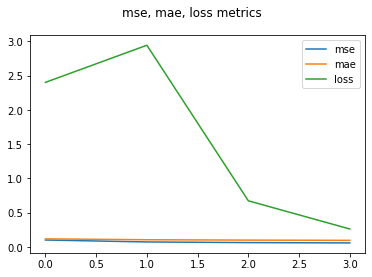

In [46]:
plot_metrics(metrics)

Нелинейная архитектура, большое количество весов, но результаты не сильно улучшились, можно посмотреть в сторону подбора лучшего lr

In [47]:
model_MaxPooling = SalaryPredictor_Pooling(pooling_func=nn.AdaptiveMaxPool1d).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_MaxPooling.parameters(), lr=5e-4)
metrics = train_with_early_stop(model_MaxPooling, criterion, optimizer, epochs=10)

10


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.18672 mse: 1.14268 mae: 0.51793 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.91271 mse: 1.01855 mae: 0.48807 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.17080 mse: 1.19704 mae: 0.53247 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.23651 mse: 1.16795 mae: 0.52596 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.66371 mse: 1.12839 mae: 0.51674 
Early stopping


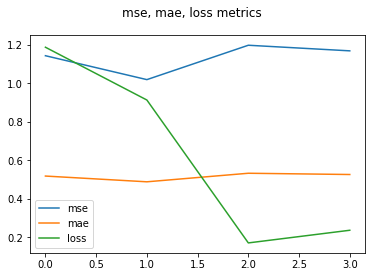

In [48]:
plot_metrics(metrics)

Можем заметить, что Pooling увеличивает точность обучения за счёт выбора более значимых фич

**3. Используйте предобученные эмбеддинги (2 балла)**

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

In [49]:
# !pip install gensim
import gensim.downloader as downloader

numbers = downloader.load('glove-wiki-gigaword-50')

emb_weights = torch.FloatTensor(numbers.vectors)

In [50]:
class SalaryPredictor_Embedding(SalaryPredictor):
    def __init__(self, n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=8, freeze=None, embeddings=None, count=50):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(embeddings, freeze=freeze)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(count, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(count, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

In [51]:
model_Embedding_Freezed = SalaryPredictor_Embedding(freeze=True, embeddings=emb_weights).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_Embedding_Freezed.parameters(), lr=1e-3)
metrics = train(model_Embedding_Freezed, criterion, optimizer, epochs=6)

6


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.15368 mse: 1.12381 mae: 0.51648 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 1.68388 mse: 0.99822 mae: 0.48607 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.55350 mse: 1.13989 mae: 0.52177 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 14.79079 mse: 0.60862 mae: 0.37414 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.19934 mse: 1.35246 mae: 0.57122 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 1.83275 mse: 0.97761 mae: 0.48266 


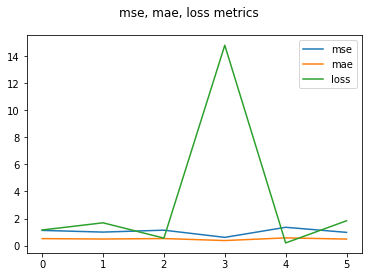

In [52]:
plot_metrics(metrics)

Неплохие результаты, но быстро обучается и прыгает loss

In [53]:
model_Embedding_NotFreezed = SalaryPredictor_Embedding(freeze=False, embeddings=emb_weights).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_Embedding_NotFreezed.parameters(), lr=1e-3)
metrics = train(model_Embedding_NotFreezed, criterion, optimizer, epochs=7)

7


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.65046 mse: 1.30509 mae: 0.55848 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.47964 mse: 1.56284 mae: 0.61424 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.41019 mse: 1.35697 mae: 0.57122 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.78772 mse: 1.25977 mae: 0.54988 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.18653 mse: 1.52655 mae: 0.60778 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.71583 mse: 1.17334 mae: 0.53050 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 6
train_loss: 2.44664 mse: 0.95148 mae: 0.47566 


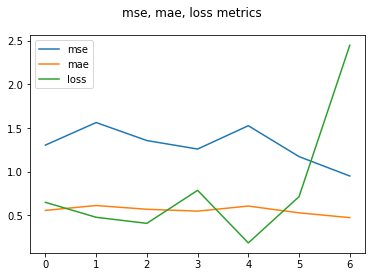

In [54]:
plot_metrics(metrics)

Без заморозки видим просадку по критерию mse

**4. Замените сверточные слои на рекуррентные (3 балла)**

* Замените сверточне слои рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

In [55]:
class SalaryPredictor_WithRNN(SalaryPredictor):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        
        self.rnn_title = nn.Sequential(
            nn.AdaptiveMaxPool1d(hid_size),
            nn.RNN(
                hid_size,            
                hid_size,
                num_layers=2,                          
                bidirectional=False
            )
        )
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.rnn_description = nn.Sequential(
            nn.AdaptiveMaxPool1d(hid_size),
            nn.RNN(
                hid_size,            
                hid_size,
                num_layers=2,                          
                bidirectional=False
            )
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.rnn_title(title_embeddings)
        title_features = self.title_encoder(title_features[0]).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.rnn_description(description_embeddings)
        description_features = self.description_encoder(description_features[0]).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [56]:
model_Embedding_WithRNN = SalaryPredictor_WithRNN().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model_Embedding_WithRNN.parameters(), lr=2e-3)
metrics = train(model_Embedding_WithRNN, criterion, optimizer, epochs=6)

6


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.86989 mse: 0.47454 mae: 0.32413 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.99646 mse: 0.57561 mae: 0.36251 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.50483 mse: 0.46657 mae: 0.32443 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.30455 mse: 0.41769 mae: 0.30613 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.41293 mse: 0.46523 mae: 0.32539 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.06637 mse: 0.46528 mae: 0.32576 


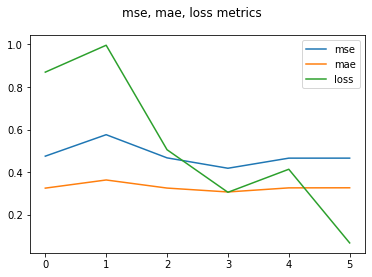

In [57]:
plot_metrics(metrics)

In [58]:
class SalaryPredictor_WithLSTM(SalaryPredictor):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        
        self.lstm_title = nn.Sequential(
            nn.AdaptiveMaxPool1d(hid_size),
            nn.LSTM(
                hid_size,            
                hid_size,
                num_layers=4,                          
                bidirectional=bidirectional
            )
        )
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.lstm_description = nn.Sequential(
            nn.AdaptiveMaxPool1d(hid_size),
            nn.LSTM(
                hid_size,            
                hid_size,
                num_layers=4,                          
                bidirectional=bidirectional
            )
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.lstm_title(title_embeddings)
        title_features = self.title_encoder(title_features[0]).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.lstm_description(description_embeddings)
        description_features = self.description_encoder(description_features[0]).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [59]:
model_Embedding_WithLSTM = SalaryPredictor_WithLSTM(bidirectional=False).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_Embedding_WithLSTM.parameters(), lr=1e-3)
metrics = train(model_Embedding_WithLSTM, criterion, optimizer, epochs=10)

10


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.52987 mse: 0.16388 mae: 0.17894 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.02280 mse: 0.12919 mae: 0.15583 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.14986 mse: 0.10660 mae: 0.13845 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.16427 mse: 0.11939 mae: 0.14859 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.01731 mse: 0.12898 mae: 0.15587 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.01492 mse: 0.12606 mae: 0.15835 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.07144 mse: 0.16262 mae: 0.18540 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.07940 mse: 0.14259 mae: 0.17245 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.04426 mse: 0.21260 mae: 0.21737 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.38491 mse: 0.17096 mae: 0.19300 


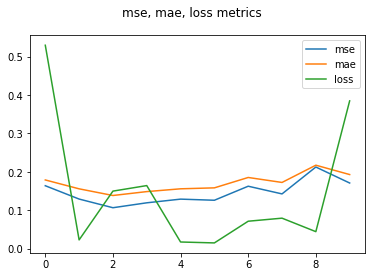

In [60]:
plot_metrics(metrics)

In [64]:
model_Embedding_WithLSTM = SalaryPredictor_WithLSTM(bidirectional=True).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_Embedding_WithLSTM.parameters(), lr=1e-3)
metrics = train(model_Embedding_WithLSTM, criterion, optimizer, epochs=10)

10


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.42705 mse: 0.55838 mae: 0.36100 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.50363 mse: 0.51357 mae: 0.34575 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.44724 mse: 0.53506 mae: 0.35368 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.25453 mse: 0.47382 mae: 0.33152 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.09345 mse: 0.53090 mae: 0.35233 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.33021 mse: 0.51843 mae: 0.34897 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.17437 mse: 0.59903 mae: 0.37759 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.29782 mse: 0.54782 mae: 0.36066 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.06399 mse: 0.61064 mae: 0.38206 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.07684 mse: 0.68117 mae: 0.40451 


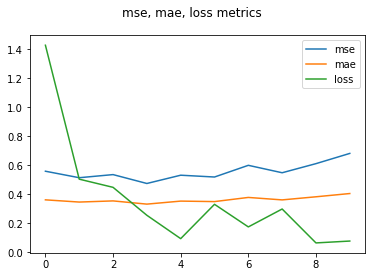

In [65]:
plot_metrics(metrics)

bidirectional ухудшил результаты, особенно это видно на mse

In [69]:
class SalaryPredictor_WithGRU(SalaryPredictor):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        
        self.gru_title = nn.Sequential(
            nn.AdaptiveMaxPool1d(hid_size),
            nn.GRU(
                hid_size,            
                hid_size,
                num_layers=1,                          
                bidirectional=bidirectional
            )
        )
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.gru_description = nn.Sequential(
            nn.AdaptiveMaxPool1d(hid_size),
            nn.GRU(
                hid_size,            
                hid_size,
                num_layers=1,                          
                bidirectional=bidirectional
            )
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.gru_title(title_embeddings)
        title_features = self.title_encoder(title_features[0]).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.gru_description(description_embeddings)
        description_features = self.description_encoder(description_features[0]).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

Получили достаточно хорошие результаты, предобученные вектора достаточно точно отражают значение слов, употребленных >= 10 раз

In [70]:
model_WithGRU = SalaryPredictor_WithGRU(bidirectional=True).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_WithGRU.parameters(), lr=1e-3)
metrics = train(model_WithGRU, criterion, optimizer, epochs=8)

8


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.51712 mse: 0.51894 mae: 0.34765 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.32461 mse: 0.54717 mae: 0.35944 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.16454 mse: 0.48874 mae: 0.34012 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.49448 mse: 0.46593 mae: 0.33249 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.18332 mse: 0.55961 mae: 0.36655 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.32036 mse: 0.47552 mae: 0.33692 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.21411 mse: 0.49241 mae: 0.34355 


  0%|          | 0/1721 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.01572 mse: 0.65526 mae: 0.39849 


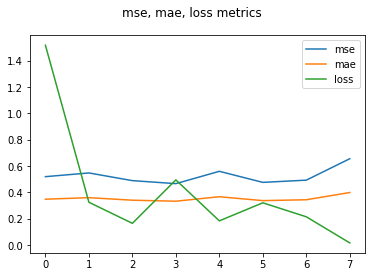

In [71]:
plot_metrics(metrics)

**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [104]:
def get_features_and_salary(model, data, 
                       device=DEVICE, 
                       batch_size=BATCH_SIZE):
    all_features = np.array([[]])
    salary = np.array([])
    for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data, 
                        batch_size=batch_size, 
                        device=device)), 
                    total=len(data) // batch_size):
        title_embeddings = model.embedder(batch['Title']).permute(0, 2, 1)
        title_features = model.gru_title(title_embeddings)
        title_features = model.title_encoder(title_features[0]).squeeze()

        description_embeddings = model.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = model.gru_description(description_embeddings)
        description_features = model.description_encoder(description_features[0]).squeeze()

        categorical_features = model.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1
        ).detach().cpu().numpy()
        if i > 0:
            all_features = np.concatenate([all_features, features])
            salary = np.concatenate([salary, batch[TARGET_COLUMN].cpu().numpy()])
        else:
            all_features = features
            salary = batch[TARGET_COLUMN].cpu().numpy()
            
    return all_features, salary       

In [106]:
features_train, salary_train = get_features_and_salary(model_WithGRU, data_train)
features_val, salary_val = get_features_and_salary(model_WithGRU, data_val)

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

In [116]:
from sklearn.tree import DecisionTreeRegressor
import random


model_regressors = []
for i in range(10):
    model_regressors.append(
        DecisionTreeRegressor(max_depth=5 + (i % 3))
    )
    
for model_regressor in tqdm.notebook.tqdm(model_regressors):
    model_regressor.fit(features_train, salary_train)

salary_val_preds = []
        
for model_regressor in model_regressors:
    salary_val_pred = model_regressor.predict(features_val)
    salary_val_preds.append(salary_val_pred)
result = np.sum(salary_val_preds, axis=0) / len(model_regressors)

print(salary_val_preds)

mse = np.mean(np.square(result - salary_val))    
mae = np.mean(np.abs(result - salary_val))
print(f"mse = {mse}, mae = {mae}")

  0%|          | 0/10 [00:00<?, ?it/s]

[array([10.24223536, 10.4062978 , 11.08416148, ..., 10.45812394,
       10.99390263, 10.61476073]), array([10.17226842, 10.35357572, 11.14477787, ..., 10.54763207,
       10.95305558, 10.67460649]), array([10.10892236, 10.30259127, 11.1262568 , ..., 10.53389306,
       10.99357298, 10.66197517]), array([10.24223536, 10.4062978 , 11.08416148, ..., 10.45812394,
       10.99390263, 10.61476073]), array([10.17226842, 10.35357572, 11.14477787, ..., 10.54763207,
       10.95305558, 10.67460649]), array([10.10892236, 10.30259127, 11.1262568 , ..., 10.53389306,
       10.99357298, 10.66197517]), array([10.24223536, 10.4062978 , 11.08416148, ..., 10.45812394,
       10.99390263, 10.61476073]), array([10.17226842, 10.35357572, 11.14477787, ..., 10.54763207,
       10.95305558, 10.67460649]), array([10.10892236, 10.30259127, 11.1262568 , ..., 10.53389306,
       10.99357298, 10.66197517]), array([10.24223536, 10.4062978 , 11.08416148, ..., 10.45812394,
       10.99390263, 10.61476073])]
mse = 0.0

In [117]:
print(salary_val)

[10.085851 10.443513 10.71444  ... 10.448744 11.082158 10.59666 ]


Ансаммбль из стандартных DecisionTreeRegressor, хороший результат, машинное обучение показывает хорошее решение и не уходит очень много времени на обучение :)
    Тестировал на GRU